In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords
import contractions
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
import fasttext
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import torch.nn.functional as F
import torch

import networkx as nx
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import norm
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import global_mean_pool

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from torch_geometric.nn import GraphConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv

from tqdm import tqdm

import random

sns.set_theme()

# Set fixed random number seed
#torch.manual_seed(42)

%matplotlib inline

In [2]:
def calculate_accuracy_precision_recall(true_labels, predicted_labels):
    return (accuracy_score(true_labels, predicted_labels),
           precision_score(true_labels, predicted_labels),
           recall_score(true_labels, predicted_labels))

def print_evaluation_results(results):
    print('Avg accuracy | Avg precision | Avg recall')
    avg_accuracy, avg_precision, avg_recall = np.mean(results, axis=0)
    std_accuracy, std_precision, std_recall = np.std(results, axis=0)
    print(f'{avg_accuracy:.4f}+-{std_accuracy:.4f}, {avg_precision:.4f}+-{std_precision:.4f}, {avg_recall:.4f}+-{std_recall:.4f}')

def get_random_number():
    return random.randint(0, 10000)

global_random_number = get_random_number()
global_random_numbers = [get_random_number() for _ in range(10)]

## Load dataset

In [3]:
df = pd.read_csv('samples.csv')
# bug == 0 and feature == 1
df = df[(df['label'] == 0) | (df['label'] == 1)]
df = df[:500]
len(df)

500

## Preprocess dataset

In [4]:
contractions.add('__label__', 'REMOVED_TOKEN')

In [5]:
# fix contractions
df['title'] = df['title'].apply(contractions.fix)
df['body'] = df['body'].apply(contractions.fix)

In [6]:
# removal of stopwords
df['title'] = df['title'].apply(remove_stopwords)
df['body'] = df['body'].apply(remove_stopwords)

## Generate statistics

In [7]:
df['number_of_words_of_title'] = df['title'].str.split().str.len()
df['number_of_words_of_body'] = df['body'].str.split().str.len()

In [8]:
x = df['number_of_words_of_title']

In [9]:
x.describe()

count    500.00000
mean       4.96000
std        1.91461
min        1.00000
25%        4.00000
50%        5.00000
75%        6.00000
max       16.00000
Name: number_of_words_of_title, dtype: float64

Text(0.5, 0, 'Number of words of title')

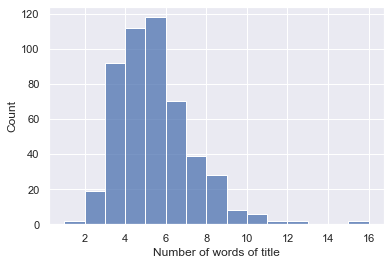

In [10]:
fig = sns.histplot(data=df, x='number_of_words_of_title', kde=False, stat='count', binwidth=1)
fig.set_xlabel('Number of words of title')
#fig.get_figure().savefig('figures/price_kde_histogram.jpg', dpi=500)

Text(0.5, 0, 'Number of words of body')

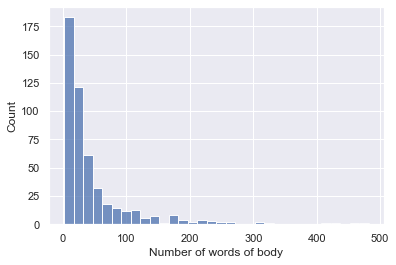

In [11]:
fig = sns.histplot(data=df, x='number_of_words_of_body', kde=False, stat='count', binwidth=15)
fig.set_xlabel('Number of words of body')
#fig.get_figure().savefig('figures/price_kde_histogram.jpg', dpi=500)

In [12]:
df['number_of_words_of_title'].describe()

count    500.00000
mean       4.96000
std        1.91461
min        1.00000
25%        4.00000
50%        5.00000
75%        6.00000
max       16.00000
Name: number_of_words_of_title, dtype: float64

In [13]:
df['number_of_words_of_body'].describe()

count    500.000000
mean      46.924000
std       64.541626
min        2.000000
25%       12.000000
50%       23.500000
75%       52.250000
max      468.000000
Name: number_of_words_of_body, dtype: float64

In [14]:
# bugs == 0
# feature == 1
df['label'].value_counts()

1    262
0    238
Name: label, dtype: int64

In [15]:
x_train, x_test = train_test_split(df.body, test_size=0.33, random_state=42)
print('Train size', len(x_train))
print('Test size', len(x_test))

Train size 335
Test size 165


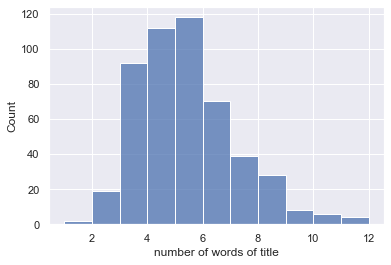

In [16]:
fig = sns.histplot(data=df[df['number_of_words_of_title'] < 15], x='number_of_words_of_title', kde=False, stat='count', binwidth=1)
fig.set_xlabel('number of words of title')
fig.get_figure().savefig('figures/number_of_words_of_title_less_than_15.pdf', dpi=500)

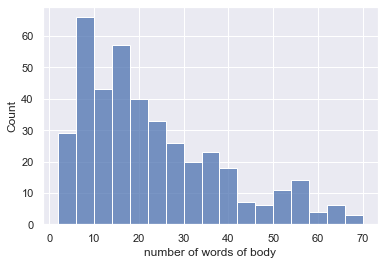

In [17]:
fig = sns.histplot(data=df[df['number_of_words_of_body'] < 70], x='number_of_words_of_body', kde=False, stat='count', binwidth=4)
fig.set_xlabel('number of words of body')
fig.get_figure().savefig('figures/number_of_words_of_body_less_than_70.pdf', dpi=500)

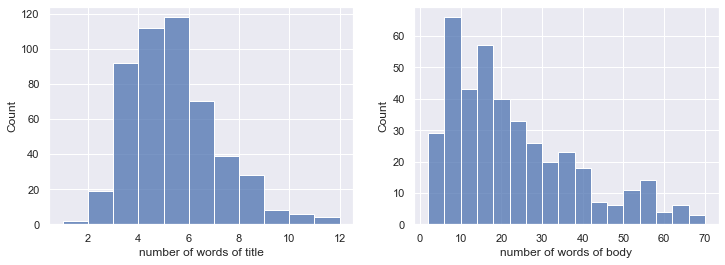

In [18]:
# print altogether
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)
ax[0].set_xlabel('number of words of title')
ax[1].set_xlabel('number of words of body')
sns.histplot(data=df[df['number_of_words_of_title'] < 15], x='number_of_words_of_title', kde=False, stat='count', binwidth=1, ax=ax[0])
sns.histplot(data=df[df['number_of_words_of_body'] < 70], x='number_of_words_of_body', kde=False, stat='count', binwidth=4, ax=ax[1])
fig.savefig('figures/title_words_less_than_15_body_words_less_than_70.pdf', dpi=500)

## Load glove embeddings 100

In [19]:
glove2word2vec('glove.6B/glove.6B.100d.txt', 'tmpfile_glove')
glove_embeddings_model = KeyedVectors.load_word2vec_format('tmpfile_glove')

In [20]:
def get_word_glove_embedding(word):
    if word not in glove_embeddings_model:
        return np.zeros(100, dtype='float32')
    return glove_embeddings_model.get_vector(word)

In [21]:
def get_sentence_glove_embedding(sentence):
    word_embeddings = [glove_embeddings_model.get_vector(word) if word in glove_embeddings_model else np.zeros(100, dtype='float32') for word in sentence.split()]
    if len(word_embeddings) == 0:
        return np.zeros(100, dtype='float32')
    return np.mean(word_embeddings, axis=0)

## Train fasttext embeddings

In [22]:
df['fasttext_input'] = '__label__' + df['label'].map(str) + ' ' + df['title'] + ' ' + df['body']
train_input, test_input = train_test_split(df.fasttext_input.values, test_size=0.33, random_state=42)
np.savetxt('train.txt', train_input, fmt='%s')
np.savetxt('test.txt', test_input, fmt='%s')
fasttext_model = fasttext.train_supervised('train.txt', dim=100, epoch=5)
fasttext_model.test('test.txt')
df.drop('fasttext_input', axis=1, inplace=True)
embeddings_lookup = {word: fasttext_model.get_word_vector(word) for word in fasttext_model.get_words()}

## Train baseline models

## GloVe + logistic regression classification

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df.body, df.label, test_size=0.33, random_state=42)
X_train = [get_sentence_glove_embedding(s) for s in X_train.values]
X_test = [get_sentence_glove_embedding(s) for s in X_test.values]

In [24]:
def run_logistic_regression_classifier(use_global_random_number=True):
    if use_global_random_number:
        random_state = global_random_number
    else:
        random_state = get_random_number()
    logit_clf = LogisticRegression(random_state=random_state, solver='liblinear').fit(X_train, y_train)
    predicted_labels = logit_clf.predict(X_test)
    true_labels = y_test
    
    results = calculate_accuracy_precision_recall(true_labels, predicted_labels)
    print(results)
    return results

In [25]:
logit_evaluation_results = []
for num in global_random_numbers:
    logit_evaluation_results.append(run_logistic_regression_classifier())

(0.7151515151515152, 0.7142857142857143, 0.7558139534883721)
(0.7151515151515152, 0.7142857142857143, 0.7558139534883721)
(0.7151515151515152, 0.7142857142857143, 0.7558139534883721)
(0.7151515151515152, 0.7142857142857143, 0.7558139534883721)
(0.7151515151515152, 0.7142857142857143, 0.7558139534883721)
(0.7151515151515152, 0.7142857142857143, 0.7558139534883721)
(0.7151515151515152, 0.7142857142857143, 0.7558139534883721)
(0.7151515151515152, 0.7142857142857143, 0.7558139534883721)
(0.7151515151515152, 0.7142857142857143, 0.7558139534883721)
(0.7151515151515152, 0.7142857142857143, 0.7558139534883721)


## <font color='red'>GloVe + logistic regression results</font>

In [26]:
print_evaluation_results(logit_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.7152+-0.0000, 0.7143+-0.0000, 0.7558+-0.0000


## GloVe + knn

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
def run_knn_regression_classifier():
    knn_clf = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)
    predicted_labels = knn_clf.predict(X_test)
    true_labels = y_test
    
    results = calculate_accuracy_precision_recall(true_labels, predicted_labels)
    print(results)
    return results

In [29]:
knn_evaluation_results = []
for num in global_random_numbers:
    knn_evaluation_results.append(run_knn_regression_classifier())

(0.696969696969697, 0.7142857142857143, 0.6976744186046512)
(0.696969696969697, 0.7142857142857143, 0.6976744186046512)
(0.696969696969697, 0.7142857142857143, 0.6976744186046512)
(0.696969696969697, 0.7142857142857143, 0.6976744186046512)
(0.696969696969697, 0.7142857142857143, 0.6976744186046512)
(0.696969696969697, 0.7142857142857143, 0.6976744186046512)
(0.696969696969697, 0.7142857142857143, 0.6976744186046512)
(0.696969696969697, 0.7142857142857143, 0.6976744186046512)
(0.696969696969697, 0.7142857142857143, 0.6976744186046512)
(0.696969696969697, 0.7142857142857143, 0.6976744186046512)


## <font color='red'>GloVe + knn results</font>

In [30]:
print_evaluation_results(knn_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.6970+-0.0000, 0.7143+-0.0000, 0.6977+-0.0000


## Fasttext classification

In [31]:
def run_fasttext_classifier():
    df['fasttext_input'] = '__label__' + df['label'].map(str) + ' ' + df['title'] + ' ' + df['body']
    train_input, test_input = train_test_split(df.fasttext_input.values, test_size=0.33, random_state=42)
    np.savetxt('train.txt', train_input, fmt='%s')
    np.savetxt('test.txt', test_input, fmt='%s')
    fasttext_model = fasttext.train_supervised('train.txt', dim=100, epoch=5)
    fasttext_model.test('test.txt')
    df.drop('fasttext_input', axis=1, inplace=True)
    embeddings_lookup = {word: fasttext_model.get_word_vector(word) for word in fasttext_model.get_words()}

    _, test_df = train_test_split(df, test_size=0.33, random_state=42)
    predicted_labels = [int(res[0].split('__label__')[1]) for res in fasttext_model.predict(test_df['body'].values.tolist())[0]]
    true_labels = test_df['label'].values
    
    results = calculate_accuracy_precision_recall(true_labels, predicted_labels)
    print(results)
    return results

In [32]:
fasttext_evaluation_results = []
for num in global_random_numbers:
    fasttext_evaluation_results.append(run_fasttext_classifier())

(0.593939393939394, 0.6, 0.6627906976744186)
(0.5878787878787879, 0.59375, 0.6627906976744186)
(0.5878787878787879, 0.59375, 0.6627906976744186)
(0.593939393939394, 0.6, 0.6627906976744186)
(0.5878787878787879, 0.59375, 0.6627906976744186)
(0.593939393939394, 0.6, 0.6627906976744186)
(0.6, 0.6041666666666666, 0.6744186046511628)
(0.5878787878787879, 0.59375, 0.6627906976744186)
(0.593939393939394, 0.5979381443298969, 0.6744186046511628)
(0.593939393939394, 0.6, 0.6627906976744186)


## <font color='red'>Fasttext results</font>

In [33]:
print_evaluation_results(fasttext_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.5921+-0.0039, 0.5977+-0.0035, 0.6651+-0.0047


## MLP

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

x_train, x_test, y_train, y_test = train_test_split(df.body, df.label, test_size=0.33, random_state=42)
x_train = [get_sentence_glove_embedding(s) for s in x_train.values]
x_test = [get_sentence_glove_embedding(s) for s in x_test.values]

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train.values).float()

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test.values).float()

x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

BATCH_SIZE = 255

# generate train dataset and train dataloader
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

# generate test dataset
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

cuda


In [35]:
class MLP(torch.nn.Module):
    def __init__(self) : 
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(100 , 250)
        self.linear2 = torch.nn.Linear(250, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [36]:
def run_mlp_classifier():
    # Initialize the MLP
    mlp = MLP().to(device)

    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

    mlp.train()
    # Run the training loop
    for epoch in range(0, 50):
        # Iterate over the DataLoader for training data
        for i, (inputs, targets) in enumerate(train_dataloader):
            # Get inputs
            targets = targets.squeeze()

            # Perform forward pass
            outputs = mlp(inputs)
            outputs = outputs.squeeze()

            # Compute loss
            loss = loss_function(outputs, targets)


            # Perform backward pass
            loss.backward()
            # Perform optimization
            optimizer.step()
            # Zero the gradients
            optimizer.zero_grad()

        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')
    # Process is complete.
    print('Training process has finished.')
    print('Final loss', loss.item())
    
    with torch.no_grad():
        mlp.eval()
        pred = mlp(test_dataset.tensors[0].to(device))
        y_true = test_dataset.tensors[1].tolist()
        y_pred = torch.round(torch.tensor(pred.tolist()).squeeze())
        results = calculate_accuracy_precision_recall(y_true, y_pred)

    print(results)
    return results

In [37]:
mlp_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    mlp_evaluation_results.append(run_mlp_classifier())

Epoch: 0, Epoch loss 0.6939725279808044
Epoch: 1, Epoch loss 0.6974061131477356
Epoch: 2, Epoch loss 0.6913110017776489
Epoch: 3, Epoch loss 0.6991488337516785
Epoch: 4, Epoch loss 0.6894136071205139
Epoch: 5, Epoch loss 0.6923815608024597
Epoch: 6, Epoch loss 0.6896109580993652
Epoch: 7, Epoch loss 0.6884811520576477
Epoch: 8, Epoch loss 0.6928006410598755
Epoch: 9, Epoch loss 0.6815938353538513
Epoch: 10, Epoch loss 0.6868463754653931
Epoch: 11, Epoch loss 0.6924707293510437
Epoch: 12, Epoch loss 0.6860308647155762
Epoch: 13, Epoch loss 0.6854805946350098
Epoch: 14, Epoch loss 0.6871264576911926
Epoch: 15, Epoch loss 0.6842005848884583
Epoch: 16, Epoch loss 0.6835455298423767
Epoch: 17, Epoch loss 0.6849431395530701
Epoch: 18, Epoch loss 0.678726851940155
Epoch: 19, Epoch loss 0.6828844547271729
Epoch: 20, Epoch loss 0.6844927668571472
Epoch: 21, Epoch loss 0.6783977746963501
Epoch: 22, Epoch loss 0.6770619750022888
Epoch: 23, Epoch loss 0.682598888874054
Epoch: 24, Epoch loss 0.6769

Epoch: 17, Epoch loss 0.68701171875
Epoch: 18, Epoch loss 0.6831392049789429
Epoch: 19, Epoch loss 0.6851047873497009
Epoch: 20, Epoch loss 0.6832281351089478
Epoch: 21, Epoch loss 0.6859477758407593
Epoch: 22, Epoch loss 0.6865493655204773
Epoch: 23, Epoch loss 0.6812556385993958
Epoch: 24, Epoch loss 0.6776191592216492
Epoch: 25, Epoch loss 0.6767606139183044
Epoch: 26, Epoch loss 0.6768493056297302
Epoch: 27, Epoch loss 0.677474856376648
Epoch: 28, Epoch loss 0.6804192662239075
Epoch: 29, Epoch loss 0.6774557828903198
Epoch: 30, Epoch loss 0.6732732653617859
Epoch: 31, Epoch loss 0.6738159656524658
Epoch: 32, Epoch loss 0.6762275099754333
Epoch: 33, Epoch loss 0.6724918484687805
Epoch: 34, Epoch loss 0.6726776957511902
Epoch: 35, Epoch loss 0.6745249629020691
Epoch: 36, Epoch loss 0.671404242515564
Epoch: 37, Epoch loss 0.6776859164237976
Epoch: 38, Epoch loss 0.6723753809928894
Epoch: 39, Epoch loss 0.6728721857070923
Epoch: 40, Epoch loss 0.6772929430007935
Epoch: 41, Epoch loss 0

Epoch: 35, Epoch loss 0.6663750410079956
Epoch: 36, Epoch loss 0.6739251017570496
Epoch: 37, Epoch loss 0.6757041215896606
Epoch: 38, Epoch loss 0.6739192008972168
Epoch: 39, Epoch loss 0.6712151169776917
Epoch: 40, Epoch loss 0.671539306640625
Epoch: 41, Epoch loss 0.6743268966674805
Epoch: 42, Epoch loss 0.6727555394172668
Epoch: 43, Epoch loss 0.6728171706199646
Epoch: 44, Epoch loss 0.6661101579666138
Epoch: 45, Epoch loss 0.6682984232902527
Epoch: 46, Epoch loss 0.673592746257782
Epoch: 47, Epoch loss 0.675574779510498
Epoch: 48, Epoch loss 0.6709033846855164
Epoch: 49, Epoch loss 0.6677277684211731
Training process has finished.
Final loss 0.6677277684211731
(0.5272727272727272, 0.524390243902439, 1.0)
Epoch: 0, Epoch loss 0.6866365075111389
Epoch: 1, Epoch loss 0.6892497539520264
Epoch: 2, Epoch loss 0.6900326013565063
Epoch: 3, Epoch loss 0.692290723323822
Epoch: 4, Epoch loss 0.6885408759117126
Epoch: 5, Epoch loss 0.6819664835929871
Epoch: 6, Epoch loss 0.682866096496582
Epoc

## <font color='red'>GloVe + MLP results</font>

In [38]:
print_evaluation_results(mlp_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.5230+-0.0039, 0.5222+-0.0020, 1.0000+-0.0000


## Train our model

In [39]:
def create_graph_of_words(text, window_size):
    text = text.split()
    G = nx.Graph()
    for i, word in enumerate(text):
        #embedding = fasttext_model.get_word_vector(word)
        embedding = embeddings_lookup.get(word, np.zeros(100, dtype='float32'))
        G.add_node(word, x=embedding)
        for j in range(i + 1, i + window_size):
            if j < len(text):
                G.add_edge(word, text[j])
    return G

def create_graph_of_words_for_pytorch(text, window_size):
    return from_networkx(create_graph_of_words(text, window_size))

def generate_pytorch_geometric_graphs(window_size):
    pyg_graphs = []
    for s in tqdm(df['body'].values):
        pyg_graphs.append(create_graph_of_words_for_pytorch(s, window_size))
    print('finished...')
    for i, label in enumerate(df['label'].values):
        pyg_graphs[i].y = torch.tensor(label).float()
    
    pyg_graphs = [g for g in pyg_graphs if g.num_nodes != 0]
    return pyg_graphs

class GATClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(12345)
        
        self.conv1 = GATConv(100, 10, heads=3)
        self.linear1 = torch.nn.Linear(10*3, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [40]:
pytorch_geometric_graphs = generate_pytorch_geometric_graphs(window_size=7)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 341.53it/s]

finished...


In [41]:
train_pyg_graphs, test_pyg_graphs = train_test_split(pytorch_geometric_graphs, test_size=0.33, random_state=42)

In [42]:
def run_gat_classifier(train_pyg_graphs, test_pyg_graphs, train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs, batch_size=200, shuffle=False)
    
    gat_model = GATClassifier().to(device)
    print(gat_model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(gat_model.parameters(), lr=learning_rate)

    gat_model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = gat_model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        gat_model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = gat_model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [43]:
gat_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    gat_evaluation_results.append(run_gat_classifier(train_pyg_graphs, test_pyg_graphs))

GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6843876838684082
Epoch: 1, Epoch loss 0.6841275095939636
Epoch: 2, Epoch loss 0.6839714050292969
Epoch: 3, Epoch loss 0.6837747693061829
Epoch: 4, Epoch loss 0.6830195784568787
Epoch: 5, Epoch loss 0.6834378838539124
Epoch: 6, Epoch loss 0.6830761432647705
Epoch: 7, Epoch loss 0.6824502348899841
Epoch: 8, Epoch loss 0.6819683909416199
Epoch: 9, Epoch loss 0.6817380785942078
Training process has finished.
Final loss 0.6817380785942078
(0.5212121212121212, 0.5212121212121212, 1.0)
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.7105657458305359
Epoch: 1, Epoch loss 0.7094062566757202
Epoch: 2, Epoch loss 0.7088292837142944
Epoch: 3, Epoch loss 0.7084373831748962
Epoch: 4, Epoch loss 0.7073332071304321
Epoch: 5, Epo

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47878787878787876, 0.0, 0.0)
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.7087830901145935
Epoch: 1, Epoch loss 0.7079454660415649
Epoch: 2, Epoch loss 0.7070721387863159
Epoch: 3, Epoch loss 0.7071141004562378
Epoch: 4, Epoch loss 0.705900251865387
Epoch: 5, Epoch loss 0.7048695683479309
Epoch: 6, Epoch loss 0.7041175961494446
Epoch: 7, Epoch loss 0.7039316296577454
Epoch: 8, Epoch loss 0.7029711008071899
Epoch: 9, Epoch loss 0.7013569474220276
Training process has finished.
Final loss 0.7013569474220276
(0.47878787878787876, 0.0, 0.0)
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.7005364298820496
Epoch: 1, Epoch loss 0.6996206045150757


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2, Epoch loss 0.6991037726402283
Epoch: 3, Epoch loss 0.6981910467147827
Epoch: 4, Epoch loss 0.6974691152572632
Epoch: 5, Epoch loss 0.6964446306228638
Epoch: 6, Epoch loss 0.6957553625106812
Epoch: 7, Epoch loss 0.6959921717643738
Epoch: 8, Epoch loss 0.6952300071716309
Epoch: 9, Epoch loss 0.6939082741737366
Training process has finished.
Final loss 0.6939082741737366
(0.47878787878787876, 0.0, 0.0)
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.7141973972320557
Epoch: 1, Epoch loss 0.713327944278717
Epoch: 2, Epoch loss 0.7127438187599182
Epoch: 3, Epoch loss 0.7113478779792786
Epoch: 4, Epoch loss 0.7107857465744019
Epoch: 5, Epoch loss 0.7097273468971252


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6, Epoch loss 0.7074467539787292
Epoch: 7, Epoch loss 0.7084646224975586
Epoch: 8, Epoch loss 0.7081958651542664
Epoch: 9, Epoch loss 0.7060623168945312
Training process has finished.
Final loss 0.7060623168945312
(0.47878787878787876, 0.0, 0.0)
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6894708871841431
Epoch: 1, Epoch loss 0.6889926195144653


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2, Epoch loss 0.6886518001556396
Epoch: 3, Epoch loss 0.6881210803985596
Epoch: 4, Epoch loss 0.6875762939453125
Epoch: 5, Epoch loss 0.6869871020317078
Epoch: 6, Epoch loss 0.6868961453437805
Epoch: 7, Epoch loss 0.6857054829597473
Epoch: 8, Epoch loss 0.6861495971679688
Epoch: 9, Epoch loss 0.6847608685493469
Training process has finished.
Final loss 0.6847608685493469
(0.5212121212121212, 0.5212121212121212, 1.0)
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.7099579572677612
Epoch: 1, Epoch loss 0.7092835307121277
Epoch: 2, Epoch loss 0.7084964513778687
Epoch: 3, Epoch loss 0.7071486115455627
Epoch: 4, Epoch loss 0.7071266770362854
Epoch: 5, Epoch loss 0.7062121033668518
Epoch: 6, Epoch loss 0.7053868174552917
Epoch: 7, Epoch loss 0.7033758759498596
Epoch: 8, Epoch loss 0.7024599313735962
Epoch: 9, Epoch loss 0.7012989521026611
Training process has finished.
Fi

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2, Epoch loss 0.7094210982322693
Epoch: 3, Epoch loss 0.7096078991889954
Epoch: 4, Epoch loss 0.7075903415679932
Epoch: 5, Epoch loss 0.7060970067977905
Epoch: 6, Epoch loss 0.7057152986526489
Epoch: 7, Epoch loss 0.7049400806427002
Epoch: 8, Epoch loss 0.7035871744155884
Epoch: 9, Epoch loss 0.7013881802558899
Training process has finished.
Final loss 0.7013881802558899
(0.47878787878787876, 0.0, 0.0)
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6986761093139648
Epoch: 1, Epoch loss 0.698249876499176
Epoch: 2, Epoch loss 0.6971059441566467
Epoch: 3, Epoch loss 0.6968747973442078
Epoch: 4, Epoch loss 0.6958085894584656


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5, Epoch loss 0.6959280967712402
Epoch: 6, Epoch loss 0.6949793100357056
Epoch: 7, Epoch loss 0.6935056447982788
Epoch: 8, Epoch loss 0.6928784251213074
Epoch: 9, Epoch loss 0.6923525333404541
Training process has finished.
Final loss 0.6923525333404541
(0.5333333333333333, 0.5279503105590062, 0.9883720930232558)
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6893386840820312
Epoch: 1, Epoch loss 0.6884620189666748
Epoch: 2, Epoch loss 0.6884499788284302
Epoch: 3, Epoch loss 0.6881098747253418
Epoch: 4, Epoch loss 0.6877833008766174
Epoch: 5, Epoch loss 0.6866801977157593
Epoch: 6, Epoch loss 0.6857159733772278
Epoch: 7, Epoch loss 0.6855570077896118
Epoch: 8, Epoch loss 0.6856387853622437
Epoch: 9, Epoch loss 0.6850975155830383
Training process has finished.
Final loss 0.6850975155830383
(0.5212121212121212, 0.5212121212121212, 1.0)


## <font color='red'>Our approach results</font>

In [44]:
print_evaluation_results(gat_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.4970+-0.0225, 0.2092+-0.2562, 0.3988+-0.4885


## Glove + GATConv

In [45]:
def create_graph_of_words_glove(text, window_size):
    text = text.split()
    G = nx.Graph()
    for i, word in enumerate(text):
        #embedding = fasttext_model.get_word_vector(word)
        embedding = get_word_glove_embedding(word)
        G.add_node(word, x=embedding)
        for j in range(i + 1, i + window_size):
            if j < len(text):
                G.add_edge(word, text[j])
    return G

def create_graph_of_words_for_pytorch_glove(text, window_size):
    return from_networkx(create_graph_of_words_glove(text, window_size))

def generate_pytorch_geometric_graphs_glove(window_size):
    pyg_graphs = []
    for s in tqdm(df['body'].values):
        pyg_graphs.append(create_graph_of_words_for_pytorch_glove(s, window_size))
    print('finished...')
    for i, label in enumerate(df['label'].values):
        pyg_graphs[i].y = torch.tensor(label).float()
    
    pyg_graphs = [g for g in pyg_graphs if g.num_nodes != 0]
    return pyg_graphs

class GATGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(12345)
        
        self.conv1 = GATConv(100, 10, heads=3)
        self.linear1 = torch.nn.Linear(10*3, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [46]:
pytorch_geometric_graphs_glove = generate_pytorch_geometric_graphs_glove(window_size=7)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 343.17it/s]

finished...


In [47]:
train_pyg_graphs_glove, test_pyg_graphs_glove = train_test_split(pytorch_geometric_graphs_glove, test_size=0.33, random_state=42)

In [48]:
def run_gat_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    gat_model = GATGloveClassifier().to(device)
    print(gat_model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(gat_model.parameters(), lr=learning_rate)

    gat_model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = gat_model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        gat_model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = gat_model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [49]:
gat_glove_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    gat_glove_evaluation_results.append(run_gat_glove_classifier())

GATGloveClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.711483359336853
Epoch: 1, Epoch loss 0.6998999714851379
Epoch: 2, Epoch loss 0.676805853843689
Epoch: 3, Epoch loss 0.6753196716308594
Epoch: 4, Epoch loss 0.6840073466300964
Epoch: 5, Epoch loss 0.6338353753089905
Epoch: 6, Epoch loss 0.641209065914154
Epoch: 7, Epoch loss 0.6874383687973022
Epoch: 8, Epoch loss 0.6753903031349182
Epoch: 9, Epoch loss 0.6681687831878662
Training process has finished.
Final loss 0.6681687831878662
(0.5212121212121212, 0.5212121212121212, 1.0)
GATGloveClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.7209498882293701
Epoch: 1, Epoch loss 0.6836686134338379
Epoch: 2, Epoch loss 0.688066840171814
Epoch: 3, Epoch loss 0.6972061395645142
Epoch: 4, Epoch loss 0.6851451992988586
Epoch: 

## <font color='red'>GloVe + GATConv results</font>

In [50]:
print_evaluation_results(gat_glove_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.5315+-0.0167, 0.5276+-0.0097, 0.9767+-0.0270


## Glove + GCNonv

In [51]:
class GCNGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(12345)
        
        self.conv1 = GCNConv(100, 10)
        self.linear1 = torch.nn.Linear(10, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [52]:
def run_gcn_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    model = GCNGloveClassifier().to(device)
    print(model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [53]:
gcn_glove_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    gcn_glove_evaluation_results.append(run_gcn_glove_classifier())

GCNGloveClassifier(
  (conv1): GCNConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.7110423445701599
Epoch: 1, Epoch loss 0.6750309467315674
Epoch: 2, Epoch loss 0.710344672203064
Epoch: 3, Epoch loss 0.6923943161964417
Epoch: 4, Epoch loss 0.6854497790336609
Epoch: 5, Epoch loss 0.7098901271820068
Epoch: 6, Epoch loss 0.6584348678588867
Epoch: 7, Epoch loss 0.6835988759994507
Epoch: 8, Epoch loss 0.6711421608924866
Epoch: 9, Epoch loss 0.6747931241989136
Training process has finished.
Final loss 0.6747931241989136
(0.5212121212121212, 0.5214723926380368, 0.9883720930232558)
GCNGloveClassifier(
  (conv1): GCNConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.7386521697044373
Epoch: 1, Epoch loss 0.7363923192024231
Epoch: 2, Epoch loss 0.7235344052314758
Epoch: 3, Epoch loss 0.7567026615142822
Epoch: 4, Epoch loss 0.7256482839584351
Epoch: 

## <font color='red'>GloVe + GCNConv results</font>

In [54]:
print_evaluation_results(gcn_glove_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.5448+-0.0409, 0.5883+-0.1073, 0.7942+-0.3165


## Glove + GraphConv

In [55]:
class GraphConvGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(12345)
        
        self.conv1 = GraphConv(100, 10, aggr='mean')
        self.linear1 = torch.nn.Linear(10, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [56]:
def run_graphconv_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    model = GraphConvGloveClassifier().to(device)
    print(model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [57]:
graphconv_glove_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    graphconv_glove_evaluation_results.append(run_graphconv_glove_classifier())

GraphConvGloveClassifier(
  (conv1): GraphConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6938874125480652
Epoch: 1, Epoch loss 0.6805741190910339
Epoch: 2, Epoch loss 0.6781912446022034
Epoch: 3, Epoch loss 0.6719853281974792
Epoch: 4, Epoch loss 0.6767652034759521
Epoch: 5, Epoch loss 0.674044668674469
Epoch: 6, Epoch loss 0.6697530746459961
Epoch: 7, Epoch loss 0.6700302958488464
Epoch: 8, Epoch loss 0.671784520149231
Epoch: 9, Epoch loss 0.6636092066764832
Training process has finished.
Final loss 0.6636092066764832
(0.5212121212121212, 0.5212121212121212, 1.0)
GraphConvGloveClassifier(
  (conv1): GraphConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.7419402599334717
Epoch: 1, Epoch loss 0.7406289577484131
Epoch: 2, Epoch loss 0.7237693667411804
Epoch: 3, Epoch loss 0.7362897396087646
Epoch: 4, Epoch loss 0.6971267461776733
Epoch: 

## <font color='red'>GloVe + GraphConv results</font>

In [58]:
print_evaluation_results(graphconv_glove_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.5552+-0.0504, 0.5477+-0.0396, 0.9465+-0.0840


## Glove + SAGEConv

In [59]:
class SAGEConvGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(12345)
        
        self.conv1 = SAGEConv(100, 10)
        self.linear1 = torch.nn.Linear(10, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [60]:
def run_sageconv_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    model = SAGEConvGloveClassifier().to(device)
    print(model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [61]:
sageconv_glove_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    sageconv_glove_evaluation_results.append(run_sageconv_glove_classifier())

SAGEConvGloveClassifier(
  (conv1): SAGEConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6938874125480652
Epoch: 1, Epoch loss 0.6805741190910339
Epoch: 2, Epoch loss 0.6781912446022034
Epoch: 3, Epoch loss 0.6719853281974792
Epoch: 4, Epoch loss 0.6767652034759521
Epoch: 5, Epoch loss 0.674044668674469
Epoch: 6, Epoch loss 0.6697530746459961
Epoch: 7, Epoch loss 0.6700302958488464
Epoch: 8, Epoch loss 0.671784520149231
Epoch: 9, Epoch loss 0.6636092066764832
Training process has finished.
Final loss 0.6636092066764832
(0.5212121212121212, 0.5212121212121212, 1.0)
SAGEConvGloveClassifier(
  (conv1): SAGEConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.7419402599334717
Epoch: 1, Epoch loss 0.7406289577484131
Epoch: 2, Epoch loss 0.7237693667411804
Epoch: 3, Epoch loss 0.7362897396087646
Epoch: 4, Epoch loss 0.6971267461776733
Epoch: 5, E

## <font color='red'>GloVe + SAGEConv results</font>

In [62]:
print_evaluation_results(sageconv_glove_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.5552+-0.0504, 0.5477+-0.0396, 0.9465+-0.0840


# Parameter Sensitivity

## Sliding window

In [63]:
def run_sliding_window_experiments():
    sliding_windows = [2, 3, 4, 6, 7, 10]
    
    sliding_window_results = []
    for sw in sliding_windows:
        print('Window size:', sw)
        pytorch_geometric_graphs = generate_pytorch_geometric_graphs(window_size=sw)
        train_pyg_graphs, test_pyg_graphs = train_test_split(pytorch_geometric_graphs, test_size=0.33, random_state=42)
        sliding_window_results.append((sw, run_gat_classifier(train_pyg_graphs, test_pyg_graphs)))
    return sliding_window_results

In [64]:
sliding_window_results = run_sliding_window_experiments()
sliding_window_results = [[sw, results[0]] for sw, results in sliding_window_results]

  0%|                                                                                                                                               | 0/500 [00:00<?, ?it/s]

Window size: 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 698.33it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6814642548561096
Epoch: 1, Epoch loss 0.6811814904212952
Epoch: 2, Epoch loss 0.6810885667800903
Epoch: 3, Epoch loss 0.6808554530143738
Epoch: 4, Epoch loss 0.6807947754859924
Epoch: 5, Epoch loss 0.6806599497795105
Epoch: 6, Epoch loss 0.6806857585906982
Epoch: 7, Epoch loss 0.6801425814628601
Epoch: 8, Epoch loss 0.6797077059745789


 14%|██████████████████▎                                                                                                                  | 69/500 [00:00<00:00, 683.16it/s]

Epoch: 9, Epoch loss 0.6800708174705505
Training process has finished.
Final loss 0.6800708174705505
(0.5212121212121212, 0.5212121212121212, 1.0)
Window size: 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 580.05it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6866601705551147
Epoch: 1, Epoch loss 0.6863527894020081
Epoch: 2, Epoch loss 0.6860342025756836
Epoch: 3, Epoch loss 0.6851943135261536
Epoch: 4, Epoch loss 0.6855088472366333
Epoch: 5, Epoch loss 0.6847372651100159
Epoch: 6, Epoch loss 0.6845728158950806
Epoch: 7, Epoch loss 0.6842480301856995
Epoch: 8, Epoch loss 0.683837890625
Epoch: 9, Epoch loss 0.6839963793754578
Training process has finished.
Final loss 0.6839963793754578


 11%|██████████████▋                                                                                                                      | 55/500 [00:00<00:00, 544.40it/s]

(0.5212121212121212, 0.5212121212121212, 1.0)
Window size: 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 481.69it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.689089834690094
Epoch: 1, Epoch loss 0.6887942552566528
Epoch: 2, Epoch loss 0.6881794333457947
Epoch: 3, Epoch loss 0.6881212592124939
Epoch: 4, Epoch loss 0.687069296836853
Epoch: 5, Epoch loss 0.6874157786369324
Epoch: 6, Epoch loss 0.6870177388191223
Epoch: 7, Epoch loss 0.6863190531730652
Epoch: 8, Epoch loss 0.6862326264381409
Epoch: 9, Epoch loss 0.6863359808921814
Training process has finished.
Final loss 0.6863359808921814


 10%|████████████▊                                                                                                                        | 48/500 [00:00<00:00, 466.03it/s]

(0.5212121212121212, 0.5212121212121212, 1.0)
Window size: 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 393.38it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6967094540596008
Epoch: 1, Epoch loss 0.6959187984466553
Epoch: 2, Epoch loss 0.6952944397926331
Epoch: 3, Epoch loss 0.6948993802070618
Epoch: 4, Epoch loss 0.6942365169525146
Epoch: 5, Epoch loss 0.6937403678894043
Epoch: 6, Epoch loss 0.6921891570091248
Epoch: 7, Epoch loss 0.6931864619255066
Epoch: 8, Epoch loss 0.6915323138237
Epoch: 9, Epoch loss 0.6900265216827393
Training process has finished.
Final loss 0.6900265216827393


  6%|███████▍                                                                                                                             | 28/500 [00:00<00:01, 277.74it/s]

(0.5212121212121212, 0.5212121212121212, 1.0)
Window size: 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 286.07it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6915401816368103
Epoch: 1, Epoch loss 0.6909775733947754
Epoch: 2, Epoch loss 0.6906204223632812
Epoch: 3, Epoch loss 0.6902115941047668
Epoch: 4, Epoch loss 0.6893751621246338
Epoch: 5, Epoch loss 0.6884915232658386


  0%|                                                                                                                                               | 0/500 [00:00<?, ?it/s]

Epoch: 6, Epoch loss 0.6880304217338562
Epoch: 7, Epoch loss 0.6879512071609497
Epoch: 8, Epoch loss 0.6861625909805298
Epoch: 9, Epoch loss 0.6865089535713196
Training process has finished.
Final loss 0.6865089535713196
(0.5212121212121212, 0.5212121212121212, 1.0)
Window size: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 276.85it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.7005727291107178
Epoch: 1, Epoch loss 0.6997285485267639
Epoch: 2, Epoch loss 0.6988826394081116
Epoch: 3, Epoch loss 0.6983574032783508
Epoch: 4, Epoch loss 0.6977064609527588
Epoch: 5, Epoch loss 0.697228193283081
Epoch: 6, Epoch loss 0.6949686408042908
Epoch: 7, Epoch loss 0.6952254176139832
Epoch: 8, Epoch loss 0.6952454447746277
Epoch: 9, Epoch loss 0.693401038646698
Training process has finished.
Final loss 0.693401038646698
(0.47878787878787876, 0.0, 0.0)


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## <font color='red'>Sliding window results</font>

In [65]:
plot_x = [res[0] for res in sliding_window_results]
plot_y = [res[1] for res in sliding_window_results]
sliding_window_results

[[2, 0.5212121212121212],
 [3, 0.5212121212121212],
 [4, 0.5212121212121212],
 [6, 0.5212121212121212],
 [7, 0.5212121212121212],
 [10, 0.47878787878787876]]

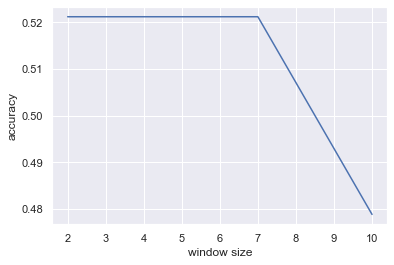

In [66]:
fig = sns.lineplot(x=plot_x, y=plot_y)
fig.set_xlabel('window size')
fig.set_ylabel('accuracy')
fig.get_figure().savefig('figures/plot_window_size.pdf', dpi=500)

In [67]:
#run_gat_classifier(train_pyg_graphs, test_pyg_graphs, train_batch_size=300, learning_rate=0.001, num_epoch=10):

## Learning rate

In [68]:
def run_learning_rate_experiments():
    learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
    
    learning_rate_results = []
    for lr in learning_rates:
        print('Learning rate:', lr)
        pytorch_geometric_graphs = generate_pytorch_geometric_graphs(window_size=2)
        train_pyg_graphs, test_pyg_graphs = train_test_split(pytorch_geometric_graphs, test_size=0.33, random_state=42)
        learning_rate_results.append((lr, run_gat_classifier(train_pyg_graphs, test_pyg_graphs, learning_rate=lr)))
    return learning_rate_results

In [69]:
learning_rate_results = run_learning_rate_experiments()
learning_rate_results = [[lr, results[0]] for lr, results in learning_rate_results]

 30%|███████████████████████████████████████                                                                                             | 148/500 [00:00<00:00, 752.27it/s]

Learning rate: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 675.68it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6798945069313049
Epoch: 1, Epoch loss 0.6799567341804504
Epoch: 2, Epoch loss 0.6798146963119507
Epoch: 3, Epoch loss 0.679885983467102
Epoch: 4, Epoch loss 0.6797970533370972
Epoch: 5, Epoch loss 0.6797604560852051


  0%|                                                                                                                                               | 0/500 [00:00<?, ?it/s]

Epoch: 6, Epoch loss 0.6797126531600952
Epoch: 7, Epoch loss 0.6796820759773254
Epoch: 8, Epoch loss 0.6796894669532776
Epoch: 9, Epoch loss 0.6797963380813599
Training process has finished.
Final loss 0.6797963380813599
(0.5212121212121212, 0.5212121212121212, 1.0)
Learning rate: 0.001


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 668.45it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6838418245315552
Epoch: 1, Epoch loss 0.683850109577179
Epoch: 2, Epoch loss 0.6835994124412537
Epoch: 3, Epoch loss 0.6833454966545105
Epoch: 4, Epoch loss 0.6833040118217468
Epoch: 5, Epoch loss 0.6826756000518799


 17%|██████████████████████▌                                                                                                              | 85/500 [00:00<00:00, 833.26it/s]

Epoch: 6, Epoch loss 0.6824786067008972
Epoch: 7, Epoch loss 0.6822915077209473
Epoch: 8, Epoch loss 0.6822258830070496
Epoch: 9, Epoch loss 0.6817572116851807
Training process has finished.
Final loss 0.6817572116851807
(0.5212121212121212, 0.5212121212121212, 1.0)
Learning rate: 0.005


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 674.76it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6948422193527222
Epoch: 1, Epoch loss 0.691303551197052
Epoch: 2, Epoch loss 0.688388466835022
Epoch: 3, Epoch loss 0.6859413981437683
Epoch: 4, Epoch loss 0.6817544102668762
Epoch: 5, Epoch loss 0.6801735758781433


  0%|                                                                                                                                               | 0/500 [00:00<?, ?it/s]

Epoch: 6, Epoch loss 0.6824923157691956
Epoch: 7, Epoch loss 0.6737936735153198
Epoch: 8, Epoch loss 0.6788474917411804
Epoch: 9, Epoch loss 0.6716408729553223
Training process has finished.
Final loss 0.6716408729553223
(0.5212121212121212, 0.5212121212121212, 1.0)
Learning rate: 0.01


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 684.02it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6860942244529724
Epoch: 1, Epoch loss 0.6824802160263062
Epoch: 2, Epoch loss 0.6808151006698608
Epoch: 3, Epoch loss 0.6787865161895752
Epoch: 4, Epoch loss 0.6688926815986633
Epoch: 5, Epoch loss 0.6739601492881775


 16%|████████████████████▋                                                                                                                | 78/500 [00:00<00:00, 772.30it/s]

Epoch: 6, Epoch loss 0.6720339059829712
Epoch: 7, Epoch loss 0.6693322658538818
Epoch: 8, Epoch loss 0.6703298687934875
Epoch: 9, Epoch loss 0.6767053008079529
Training process has finished.
Final loss 0.6767053008079529
(0.5212121212121212, 0.5212121212121212, 1.0)
Learning rate: 0.05


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 675.68it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6850773692131042
Epoch: 1, Epoch loss 0.6700172424316406
Epoch: 2, Epoch loss 0.6625494956970215
Epoch: 3, Epoch loss 0.690070390701294
Epoch: 4, Epoch loss 0.6763512492179871
Epoch: 5, Epoch loss 0.6689558029174805

  0%|                                                                                                                                               | 0/500 [00:00<?, ?it/s]


Epoch: 6, Epoch loss 0.6589022278785706
Epoch: 7, Epoch loss 0.6614523530006409
Epoch: 8, Epoch loss 0.6587381362915039
Epoch: 9, Epoch loss 0.6391745209693909
Training process has finished.
Final loss 0.6391745209693909
(0.5454545454545454, 0.5345911949685535, 0.9883720930232558)
Learning rate: 0.1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 687.73it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6644680500030518
Epoch: 1, Epoch loss 0.6969080567359924
Epoch: 2, Epoch loss 0.7279341816902161
Epoch: 3, Epoch loss 0.6571053862571716
Epoch: 4, Epoch loss 0.6553293466567993
Epoch: 5, Epoch loss 0.641385555267334


 16%|████████████████████▋                                                                                                                | 78/500 [00:00<00:00, 772.28it/s]

Epoch: 6, Epoch loss 0.6511122584342957
Epoch: 7, Epoch loss 0.6061235666275024
Epoch: 8, Epoch loss 0.6286087036132812
Epoch: 9, Epoch loss 0.5896900296211243
Training process has finished.
Final loss 0.5896900296211243
(0.5636363636363636, 0.5555555555555556, 0.813953488372093)
Learning rate: 0.5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 678.43it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.8906390070915222
Epoch: 1, Epoch loss 1.5578111410140991
Epoch: 2, Epoch loss 0.7739527225494385
Epoch: 3, Epoch loss 1.3090099096298218
Epoch: 4, Epoch loss 0.6416475772857666
Epoch: 5, Epoch loss 0.6639130711555481
Epoch: 6, Epoch loss 0.6610374450683594
Epoch: 7, Epoch loss 0.6939212679862976
Epoch: 8, Epoch loss 0.6182901859283447
Epoch: 9, Epoch loss 0.5565651655197144
Training process has finished.
Final loss 0.5565651655197144
(0.5333333333333333, 0.5279503105590062, 0.9883720930232558)


## <font color='red'>Learning rate results</font>

In [70]:
plot_x = [res[0] for res in learning_rate_results]
plot_y = [res[1] for res in learning_rate_results]
learning_rate_results

[[0.0001, 0.5212121212121212],
 [0.001, 0.5212121212121212],
 [0.005, 0.5212121212121212],
 [0.01, 0.5212121212121212],
 [0.05, 0.5454545454545454],
 [0.1, 0.5636363636363636],
 [0.5, 0.5333333333333333]]

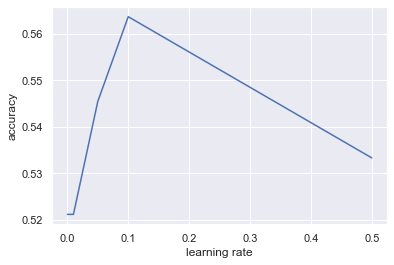

In [71]:
fig = sns.lineplot(x=plot_x, y=plot_y)
fig.set_xlabel('learning rate')
fig.set_ylabel('accuracy')
fig.get_figure().savefig('figures/plot_learning_rate.pdf', dpi=500)

In [72]:
#run_gat_classifier(train_pyg_graphs, test_pyg_graphs, train_batch_size=300, learning_rate=0.001, num_epoch=10):

## Training size

In [73]:
def run_training_size_experiments():
    training_sizes = [0.1, 0.2, 0.33, 0.5, 0.6, 0.7]
    
    training_size_results = []
    for ts in training_sizes:
        print('Training size:', ts)
        pytorch_geometric_graphs = generate_pytorch_geometric_graphs(window_size=2)
        train_pyg_graphs, test_pyg_graphs = train_test_split(pytorch_geometric_graphs, test_size=ts, random_state=42)
        training_size_results.append((ts, run_gat_classifier(train_pyg_graphs, test_pyg_graphs)))
    return training_size_results

In [74]:
training_size_results = run_training_size_experiments()
training_size_results = [[ts, results[0]] for ts, results in training_size_results]

 16%|█████████████████████▌                                                                                                               | 81/500 [00:00<00:00, 801.96it/s]

Training size: 0.1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 694.44it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.7004979848861694
Epoch: 1, Epoch loss 0.7000174522399902
Epoch: 2, Epoch loss 0.699591338634491
Epoch: 3, Epoch loss 0.6987468600273132
Epoch: 4, Epoch loss 0.6984322667121887
Epoch: 5, Epoch loss 0.6984917521476746
Epoch: 6, Epoch loss 0.6976265907287598
Epoch: 7, Epoch loss 0.6968327760696411
Epoch: 8, Epoch loss 0.6965172290802002
Epoch: 9, Epoch loss 0.6970841288566589
Training process has finished.
Final loss 0.6970841288566589


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 32%|█████████████████████████████████████████▉                                                                                          | 159/500 [00:00<00:00, 808.30it/s]

(0.52, 0.0, 0.0)
Training size: 0.2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 686.81it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.687878429889679
Epoch: 1, Epoch loss 0.6878551840782166
Epoch: 2, Epoch loss 0.687704861164093
Epoch: 3, Epoch loss 0.6875976920127869
Epoch: 4, Epoch loss 0.6876085996627808
Epoch: 5, Epoch loss 0.687429666519165
Epoch: 6, Epoch loss 0.6872216463088989
Epoch: 7, Epoch loss 0.6874008178710938
Epoch: 8, Epoch loss 0.6870077252388
Epoch: 9, Epoch loss 0.686996579170227
Training process has finished.
Final loss 0.686996579170227


 29%|██████████████████████████████████████                                                                                              | 144/500 [00:00<00:00, 745.33it/s]

(0.5, 0.5, 1.0)
Training size: 0.33


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 688.65it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6812720894813538
Epoch: 1, Epoch loss 0.6812450885772705
Epoch: 2, Epoch loss 0.6812215447425842
Epoch: 3, Epoch loss 0.6808196306228638
Epoch: 4, Epoch loss 0.6807940006256104
Epoch: 5, Epoch loss 0.6807082295417786


 17%|██████████████████████▌                                                                                                              | 85/500 [00:00<00:00, 841.59it/s]

Epoch: 6, Epoch loss 0.6805450916290283
Epoch: 7, Epoch loss 0.6805607080459595
Epoch: 8, Epoch loss 0.6801873445510864
Epoch: 9, Epoch loss 0.6803408861160278
Training process has finished.
Final loss 0.6803408861160278
(0.5212121212121212, 0.5212121212121212, 1.0)
Training size: 0.5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 718.34it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6926453113555908
Epoch: 1, Epoch loss 0.6925926208496094
Epoch: 2, Epoch loss 0.6925099492073059
Epoch: 3, Epoch loss 0.6924307346343994
Epoch: 4, Epoch loss 0.6923901438713074
Epoch: 5, Epoch loss 0.6924326419830322
Epoch: 6, Epoch loss 0.6923126578330994
Epoch: 7, Epoch loss 0.6924185156822205
Epoch: 8, Epoch loss 0.6921278238296509
Epoch: 9, Epoch loss 0.6923841834068298
Training process has finished.
Final loss 0.6923841834068298


 17%|██████████████████████▌                                                                                                              | 85/500 [00:00<00:00, 833.35it/s]

(0.528, 0.528, 1.0)
Training size: 0.6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 699.27it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.6987025141716003
Epoch: 1, Epoch loss 0.6985381841659546
Epoch: 2, Epoch loss 0.698310375213623
Epoch: 3, Epoch loss 0.6981117725372314
Epoch: 4, Epoch loss 0.6979269981384277
Epoch: 5, Epoch loss 0.6975569128990173
Epoch: 6, Epoch loss 0.6974378228187561
Epoch: 7, Epoch loss 0.6971491575241089
Epoch: 8, Epoch loss 0.6971958875656128
Epoch: 9, Epoch loss 0.6966565251350403
Training process has finished.
Final loss 0.6966565251350403


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 18%|███████████████████████▋                                                                                                             | 89/500 [00:00<00:00, 855.78it/s]

(0.4666666666666667, 0.0, 0.0)
Training size: 0.7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 721.47it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.699819028377533
Epoch: 1, Epoch loss 0.6994867324829102
Epoch: 2, Epoch loss 0.6992545127868652
Epoch: 3, Epoch loss 0.6990649104118347
Epoch: 4, Epoch loss 0.6986282467842102
Epoch: 5, Epoch loss 0.6986995339393616
Epoch: 6, Epoch loss 0.6981638669967651
Epoch: 7, Epoch loss 0.6981915235519409
Epoch: 8, Epoch loss 0.698025643825531
Epoch: 9, Epoch loss 0.6978331208229065
Training process has finished.
Final loss 0.6978331208229065
(0.47714285714285715, 0.0, 0.0)


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## <font color='red'>Training size results</font>

In [75]:
plot_x = [res[0] for res in training_size_results]
plot_y = [res[1] for res in training_size_results]
training_size_results

[[0.1, 0.52],
 [0.2, 0.5],
 [0.33, 0.5212121212121212],
 [0.5, 0.528],
 [0.6, 0.4666666666666667],
 [0.7, 0.47714285714285715]]

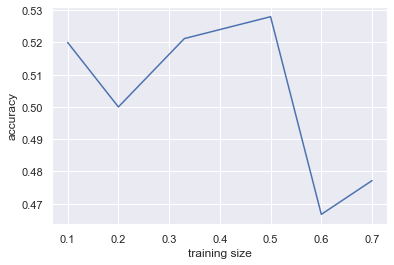

In [76]:
fig = sns.lineplot(x=plot_x, y=plot_y)
fig.set_xlabel('training size')
fig.set_ylabel('accuracy')
fig.get_figure().savefig('figures/training_size_rate.pdf', dpi=500)

## Draw an exemplar graph-of-words graph with 15 nodes and 3 window size

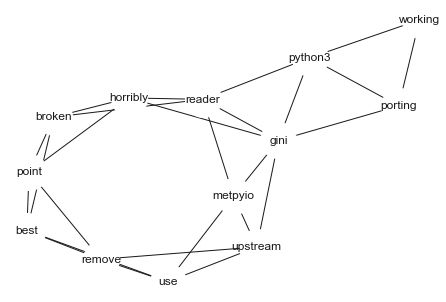

In [77]:
text = df['body'][df['number_of_words_of_body'] == 15].values[6]
text = text.replace(',', '')
text = text.replace('.', '')
g = create_graph_of_words(text, 3)
nx.draw_kamada_kawai(g, with_labels=True, node_color='white', node_size=1300)
plt.savefig("Graph1.pdf")
plt.show()